In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/feature-engineered/reg_df_reduced.csv')


=== Evaluation on Test ===
recession_probability: MAE=1.8613, RMSE=11.6323, R2=0.5445
1_month_recession_probability: MAE=4.7710, RMSE=20.0359, R2=-0.3518
3_month_recession_probability: MAE=4.1106, RMSE=16.7152, R2=-0.8527
6_month_recession_probability: MAE=9.5985, RMSE=12.9061, R2=-713.6312


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

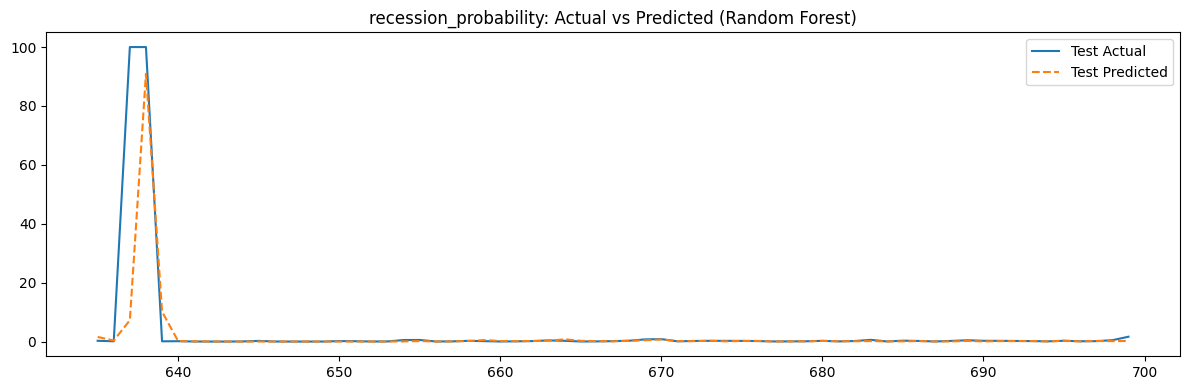

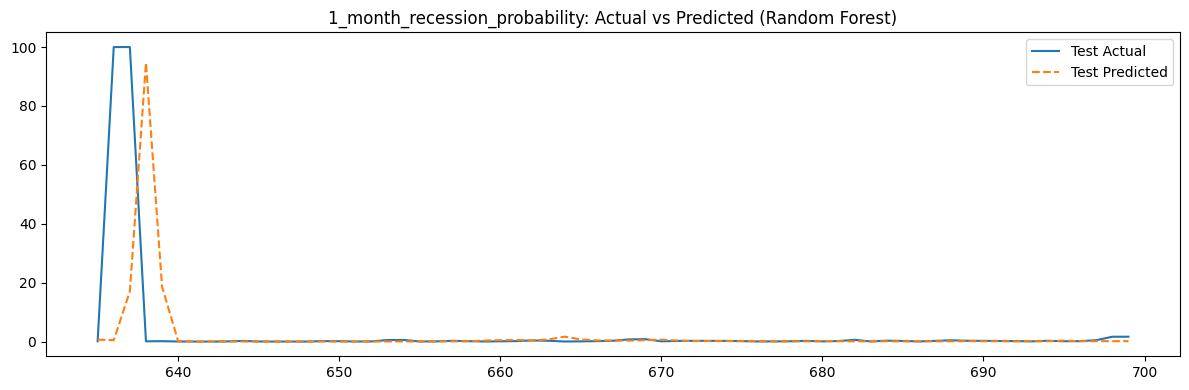

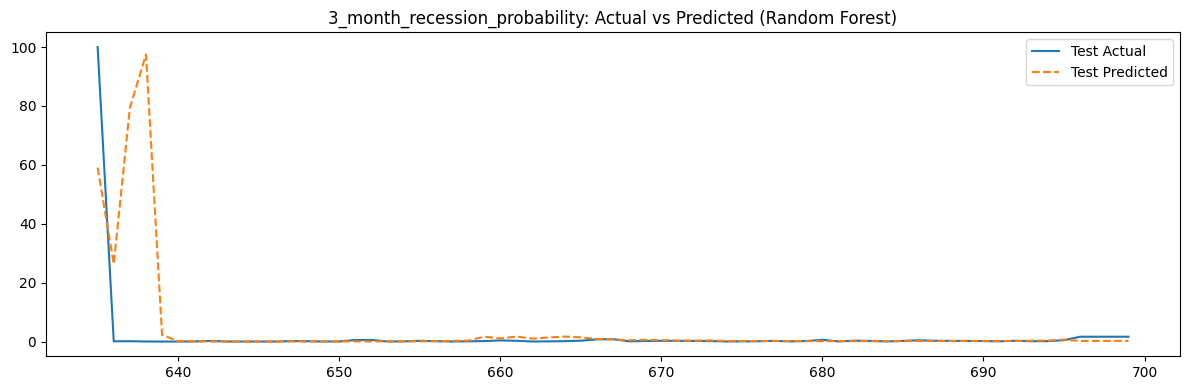

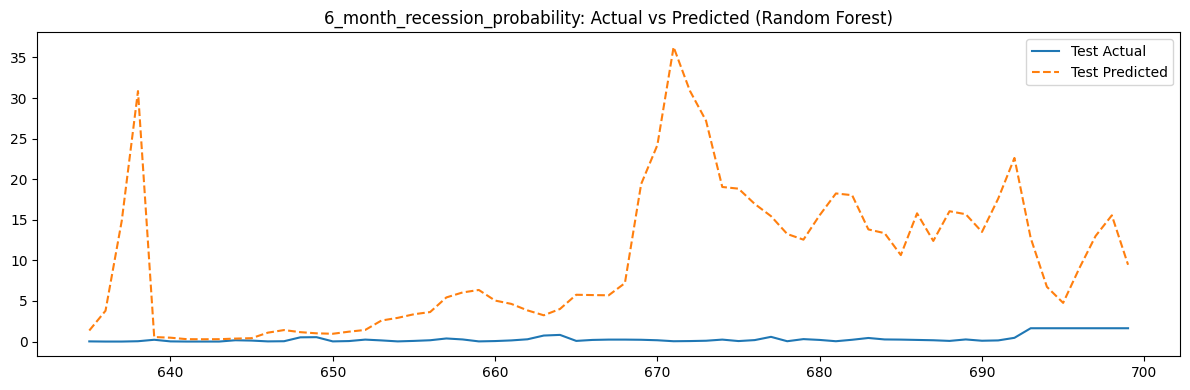

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Key indicators to keep
# -------------------------
key_indicators = [
    '1_year_rate','3_months_rate','6_months_rate','CPI','INDPRO',
    '10_year_rate','share_price','unemployment_rate','PPI',
    'OECD_CLI_index','CSI_index','gdp_per_capita'
]

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Feature reduction per target
# -------------------------
top_features_dict = {}
for target in recession_targets:
    rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train[target])
    
    selector = SelectFromModel(rf, prefit=True, max_features=30, threshold=-np.inf)
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    for f in key_indicators:
        if f not in selected_features and f in X_train.columns:
            selected_features.append(f)
    
    top_features_dict[target] = selected_features

# -------------------------
# Logit transform for [0,100] probabilities
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Train Random Forest per target
# -------------------------
preds_test = pd.DataFrame(index=test_df.index)
models = {}

for target in recession_targets:
    X_train_target = X_train[top_features_dict[target]]
    X_test_target  = X_test[top_features_dict[target]]
    
    y_train_target = y_train[target].values
    y_test_target  = y_test[target].values

    if np.std(y_train_target) < 1e-3:
        print(f"⚠️ {target} is nearly constant. Predicting mean.")
        preds_test[target] = np.full(len(y_test_target), np.mean(y_train_target))
        models[target] = None
        continue

    # Apply logit transform
    y_train_logit = logit_transform(y_train_target)

    # Random Forest parameters
    rf_params = {
        "n_estimators": 1000,
        "max_depth": 8,
        "min_samples_split": 5,
        "min_samples_leaf": 3,
        "max_features": "sqrt",
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**rf_params)
    model.fit(X_train_target, y_train_logit)

    # Predict and invert logit
    y_pred_logit = model.predict(X_test_target)
    y_pred = inv_logit_transform(y_pred_logit)
    preds_test[target] = np.clip(y_pred, 0, 100)
    models[target] = model

# -------------------------
# Evaluation
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(test_df.index, preds_test[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted (Random Forest)")
    plt.legend()
    plt.tight_layout()
    plt.show()
